In [14]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [16]:
random_seed= 42

In [17]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train3"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test3"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # gray scale for shape ?
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            y_label = torch.tensor(np.eye(self.nrofclass)[Category])
            #y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label]) # one hot encoding
            
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2575.46it/s]


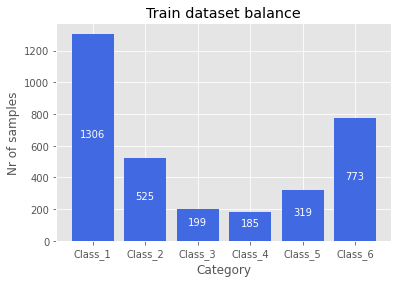

In [5]:
# Checking for class balance
DataSummary = []
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)
    
DataBalance = dict(zip(DataSetTrain.data.classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [8]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

In [6]:
# Initialise class weights
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain):
        class_weight = class_weights[label.argmax()]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [9]:
#Data loaders
BATCH_SIZE = 20
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=True
                              )


In [11]:
""" Vision Transformer (ViT) in PyTorch

A PyTorch implement of Vision Transformers as described in:

'An Image Is Worth 16 x 16 Words: Transformers for Image Recognition at Scale'
    - https://arxiv.org/abs/2010.11929

`How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers`
    - https://arxiv.org/abs/2106.10270

The official jax code is released and available at https://github.com/google-research/vision_transformer

DeiT model defs and weights from https://github.com/facebookresearch/deit,
paper `DeiT: Data-efficient Image Transformers` - https://arxiv.org/abs/2012.12877

Acknowledgments:
* The paper authors for releasing code and weights, thanks!
* I fixed my class token impl based on Phil Wang's https://github.com/lucidrains/vit-pytorch ... check it out
for some einops/einsum fun
* Simple transformer style inspired by Andrej Karpathy's https://github.com/karpathy/minGPT
* Bert reference code checks against Huggingface Transformers and Tensorflow Bert

Hacked together by / Copyright 2020, Ross Wightman
"""
import math
import logging
from functools import partial
from collections import OrderedDict
from copy import deepcopy

import torch
#import torch.nn as nn
#import torch.nn.functional as F

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, named_apply, adapt_input_conv
from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from timm.models.registry import register_model

_logger = logging.getLogger(__name__)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 6, 'input_size': (1, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    # patch models (weights from official Google JAX impl)
    'vit_tiny_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_tiny_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_small_patch32_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch32_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_small_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_base_patch32_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_base_patch32_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_base_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz'),
    'vit_base_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_base_patch8_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'B_8-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz'),
    'vit_large_patch32_224': _cfg(
        url='',  # no official model weights for this combo, only for in21k
        ),
    'vit_large_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p32_384-9b920ba8.pth',
        input_size=(3, 384, 384), crop_pct=1.0),
    'vit_large_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_224.npz'),
    'vit_large_patch16_384': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384.npz',
        input_size=(3, 384, 384), crop_pct=1.0),

    'vit_huge_patch14_224': _cfg(url=''),
    'vit_giant_patch14_224': _cfg(url=''),
    'vit_gigantic_patch14_224': _cfg(url=''),

    # patch models, imagenet21k (weights from official Google JAX impl)
    'vit_tiny_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_small_patch32_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_small_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_base_patch32_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/B_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.03-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_base_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_base_patch8_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/B_8-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0.npz',
        num_classes=21843),
    'vit_large_patch32_224_in21k': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth',
        num_classes=21843),
    'vit_large_patch16_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1.npz',
        num_classes=21843),
    'vit_huge_patch14_224_in21k': _cfg(
        url='https://storage.googleapis.com/vit_models/imagenet21k/ViT-H_14.npz',
        hf_hub='timm/vit_huge_patch14_224_in21k',
        num_classes=21843),

    # SAM trained models (https://arxiv.org/abs/2106.01548)
    'vit_base_patch32_sam_224': _cfg(
        url='https://storage.googleapis.com/vit_models/sam/ViT-B_32.npz'),
    'vit_base_patch16_sam_224': _cfg(
        url='https://storage.googleapis.com/vit_models/sam/ViT-B_16.npz'),

    # deit models (FB weights)
    'deit_tiny_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    'deit_small_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    'deit_base_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    'deit_base_patch16_384': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, input_size=(3, 384, 384), crop_pct=1.0),
    'deit_tiny_distilled_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_tiny_distilled_patch16_224-b40b3cf7.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, classifier=('head', 'head_dist')),
    'deit_small_distilled_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_small_distilled_patch16_224-649709d9.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, classifier=('head', 'head_dist')),
    'deit_base_distilled_patch16_224': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_224-df68dfff.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, classifier=('head', 'head_dist')),
    'deit_base_distilled_patch16_384': _cfg(
        url='https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth',
        mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, input_size=(3, 384, 384), crop_pct=1.0,
        classifier=('head', 'head_dist')),

    # ViT ImageNet-21K-P pretraining by MILL
    'vit_base_patch16_224_miil_in21k': _cfg(
        url='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ImageNet_21K_P/models/timm/vit_base_patch16_224_in21k_miil.pth',
        mean=(0, 0, 0), std=(1, 1, 1), crop_pct=0.875, interpolation='bilinear', num_classes=11221,
    ),
    'vit_base_patch16_224_miil': _cfg(
        url='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ImageNet_21K_P/models/timm'
            '/vit_base_patch16_224_1k_miil_84_4.pth',
        mean=(0, 0, 0), std=(1, 1, 1), crop_pct=0.875, interpolation='bilinear',
    ),
}


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer

    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929

    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init=''):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


@torch.no_grad()
def _load_weights(model: VisionTransformer, checkpoint_path: str, prefix: str = ''):
    """ Load weights from .npz checkpoints for official Google Brain Flax implementation
    """
    import numpy as np

    def _n2p(w, t=True):
        if w.ndim == 4 and w.shape[0] == w.shape[1] == w.shape[2] == 1:
            w = w.flatten()
        if t:
            if w.ndim == 4:
                w = w.transpose([3, 2, 0, 1])
            elif w.ndim == 3:
                w = w.transpose([2, 0, 1])
            elif w.ndim == 2:
                w = w.transpose([1, 0])
        return torch.from_numpy(w)

    w = np.load(checkpoint_path)
    if not prefix and 'opt/target/embedding/kernel' in w:
        prefix = 'opt/target/'

    if hasattr(model.patch_embed, 'backbone'):
        # hybrid
        backbone = model.patch_embed.backbone
        stem_only = not hasattr(backbone, 'stem')
        stem = backbone if stem_only else backbone.stem
        stem.conv.weight.copy_(adapt_input_conv(stem.conv.weight.shape[1], _n2p(w[f'{prefix}conv_root/kernel'])))
        stem.norm.weight.copy_(_n2p(w[f'{prefix}gn_root/scale']))
        stem.norm.bias.copy_(_n2p(w[f'{prefix}gn_root/bias']))
        if not stem_only:
            for i, stage in enumerate(backbone.stages):
                for j, block in enumerate(stage.blocks):
                    bp = f'{prefix}block{i + 1}/unit{j + 1}/'
                    for r in range(3):
                        getattr(block, f'conv{r + 1}').weight.copy_(_n2p(w[f'{bp}conv{r + 1}/kernel']))
                        getattr(block, f'norm{r + 1}').weight.copy_(_n2p(w[f'{bp}gn{r + 1}/scale']))
                        getattr(block, f'norm{r + 1}').bias.copy_(_n2p(w[f'{bp}gn{r + 1}/bias']))
                    if block.downsample is not None:
                        block.downsample.conv.weight.copy_(_n2p(w[f'{bp}conv_proj/kernel']))
                        block.downsample.norm.weight.copy_(_n2p(w[f'{bp}gn_proj/scale']))
                        block.downsample.norm.bias.copy_(_n2p(w[f'{bp}gn_proj/bias']))
        embed_conv_w = _n2p(w[f'{prefix}embedding/kernel'])
    else:
        embed_conv_w = adapt_input_conv(
            model.patch_embed.proj.weight.shape[1], _n2p(w[f'{prefix}embedding/kernel']))
    model.patch_embed.proj.weight.copy_(embed_conv_w)
    model.patch_embed.proj.bias.copy_(_n2p(w[f'{prefix}embedding/bias']))
    model.cls_token.copy_(_n2p(w[f'{prefix}cls'], t=False))
    pos_embed_w = _n2p(w[f'{prefix}Transformer/posembed_input/pos_embedding'], t=False)
    if pos_embed_w.shape != model.pos_embed.shape:
        pos_embed_w = resize_pos_embed(  # resize pos embedding when different size from pretrained weights
            pos_embed_w, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
    model.pos_embed.copy_(pos_embed_w)
    model.norm.weight.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/bias']))
    if isinstance(model.head, nn.Linear) and model.head.bias.shape[0] == w[f'{prefix}head/bias'].shape[-1]:
        model.head.weight.copy_(_n2p(w[f'{prefix}head/kernel']))
        model.head.bias.copy_(_n2p(w[f'{prefix}head/bias']))
    if isinstance(getattr(model.pre_logits, 'fc', None), nn.Linear) and f'{prefix}pre_logits/bias' in w:
        model.pre_logits.fc.weight.copy_(_n2p(w[f'{prefix}pre_logits/kernel']))
        model.pre_logits.fc.bias.copy_(_n2p(w[f'{prefix}pre_logits/bias']))
    for i, block in enumerate(model.blocks.children()):
        block_prefix = f'{prefix}Transformer/encoderblock_{i}/'
        mha_prefix = block_prefix + 'MultiHeadDotProductAttention_1/'
        block.norm1.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/scale']))
        block.norm1.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/bias']))
        block.attn.qkv.weight.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/kernel'], t=False).flatten(1).T for n in ('query', 'key', 'value')]))
        block.attn.qkv.bias.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/bias'], t=False).reshape(-1) for n in ('query', 'key', 'value')]))
        block.attn.proj.weight.copy_(_n2p(w[f'{mha_prefix}out/kernel']).flatten(1))
        block.attn.proj.bias.copy_(_n2p(w[f'{mha_prefix}out/bias']))
        for r in range(2):
            getattr(block.mlp, f'fc{r + 1}').weight.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/kernel']))
            getattr(block.mlp, f'fc{r + 1}').bias.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/bias']))
        block.norm2.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/scale']))
        block.norm2.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/bias']))


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, default_cfg=None, **kwargs):
    default_cfg = default_cfg or default_cfgs[variant]
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    # NOTE this extra code to support handling of repr size for in21k pretrained models
    default_num_classes = default_cfg['num_classes']
    num_classes = kwargs.get('num_classes', default_num_classes)
    repr_size = kwargs.pop('representation_size', None)
    if repr_size is not None and num_classes != default_num_classes:
        # Remove representation layer if fine-tuning. This may not always be the desired action,
        # but I feel better than doing nothing by default for fine-tuning. Perhaps a better interface?
        _logger.warning("Removing representation layer for fine-tuning.")
        repr_size = None

    model = build_model_with_cfg(
        VisionTransformer, variant, pretrained,
        default_cfg=default_cfg,
        representation_size=repr_size,
        pretrained_filter_fn=checkpoint_filter_fn,
        pretrained_custom_load='npz' in default_cfg['url'],
        **kwargs)
    return model


def vit_base_patch16_224(pretrained=False, **kwargs):
    """ ViT-Base (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights fine-tuned from in21k @ 224x224, source https://github.com/google-research/vision_transformer.
    """
    model_kwargs = dict(patch_size=16, embed_dim=768, depth=12, num_heads=12, **kwargs)
    model = _create_vision_transformer('vit_base_patch16_224', pretrained=pretrained, **model_kwargs)
    return model


def vit_large_patch16_224(pretrained=False, **kwargs):
    """ ViT-Large model (ViT-L/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights fine-tuned from in21k @ 224x224, source https://github.com/google-research/vision_transformer.
    """
    model_kwargs = dict(patch_size=16, embed_dim=1024, depth=24, num_heads=16, **kwargs)
    model = _create_vision_transformer('vit_large_patch16_224', pretrained=pretrained, **model_kwargs)
    return model


def vit_huge_patch14_224(pretrained=False, **kwargs):
    """ ViT-Huge model (ViT-H/14) from original paper (https://arxiv.org/abs/2010.11929).
    """
    model_kwargs = dict(patch_size=14, embed_dim=1280, depth=32, num_heads=16, **kwargs)
    model = _create_vision_transformer('vit_huge_patch14_224', pretrained=pretrained, **model_kwargs)
    return model

def vit_giant_patch14_224(pretrained=False, **kwargs):
    """ ViT-Giant model (ViT-g/14) from `Scaling Vision Transformers` - https://arxiv.org/abs/2106.04560
    """
    model_kwargs = dict(patch_size=14, embed_dim=1408, mlp_ratio=48/11, depth=40, num_heads=16, **kwargs)
    model = _create_vision_transformer('vit_giant_patch14_224', pretrained=pretrained, **model_kwargs)
    return model

def vit_small_patch16_224_in21k(pretrained=False, **kwargs):
    """ ViT-Small (ViT-S/16)
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    NOTE: this model has valid 21k classifier head and no representation (pre-logits) layer
    """
    model_kwargs = dict(patch_size=16, embed_dim=384, depth=12, num_heads=6, **kwargs)
    model = _create_vision_transformer('vit_small_patch16_224_in21k', pretrained=pretrained, **model_kwargs)
    return model

def vit_base_patch16_224_in21k(pretrained=False, **kwargs):
    """ ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    NOTE: this model has valid 21k classifier head and no representation (pre-logits) layer
    """
    model_kwargs = dict(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, **kwargs)
    model = _create_vision_transformer('vit_base_patch16_224_in21k', pretrained=pretrained, **model_kwargs)
    return model

In [12]:
net= vit_base_patch16_224()
net.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

In [ ]:
EPOCHS = 100
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()
steps = len(train_data_loader)
stepsv = len(test_data_loader)
val_losses = []
train_losses = []
val_accs = []
train_accs = []
for epoch in range(EPOCHS):
    total = 0
    train_acc = 0
    train_loss = 0
    net.train()
    for step in tqdm(range(steps)):
        x, y = next(iter(train_data_loader))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step() 
        
        total += y.size(0)
        
        _, predicted = outputs.max(1)
  
        train_acc += (predicted == y.max(1).indices).sum().cpu().detach().numpy()
        train_loss += loss.item()
        
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)
    
    totalv = 0
    val_acc = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = net(vinputs)
            
            vloss = loss_function(voutputs, vlabels)
            
            totalv += vlabels.size(0)
        
            _, predictedv = voutputs.max(1)
            
            val_acc += (predictedv == vlabels.max(1).indices).sum().cpu().detach().numpy()
            val_loss += vloss.item()
            
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
    
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.10it/s]


Epoch: 0. Loss: 0.4904704259107163. Validation Loss: 1.7042232752862303
Train accuracy: 17.228915662650603. Validation accuracy: 40.333333333333336


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  5.98it/s]


Epoch: 1. Loss: 0.4657723298131764. Validation Loss: 1.9723811509200566
Train accuracy: 17.89156626506024. Validation accuracy: 12.666666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.05it/s]


Epoch: 2. Loss: 0.46356436852272254. Validation Loss: 1.7196027143999482
Train accuracy: 16.44578313253012. Validation accuracy: 22.11111111111111


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.04it/s]


Epoch: 3. Loss: 0.46203092288872966. Validation Loss: 1.962413221253364
Train accuracy: 16.02409638554217. Validation accuracy: 23.0


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.00it/s]


Epoch: 4. Loss: 0.46006878135224677. Validation Loss: 1.7401053241425841
Train accuracy: 14.728915662650602. Validation accuracy: 38.888888888888886


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.03it/s]


Epoch: 5. Loss: 0.4593953141908958. Validation Loss: 1.8634513621754716
Train accuracy: 16.837349397590362. Validation accuracy: 4.555555555555555


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  5.95it/s]


Epoch: 6. Loss: 0.4565918664552691. Validation Loss: 1.7712413387993975
Train accuracy: 16.1144578313253. Validation accuracy: 19.88888888888889


 60%|████████████████████████████████████████████████▎                                | 99/166 [00:51<00:34,  1.95it/s]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
net.eval()
confusion_matrix = torch.zeros(6, 6, dtype=torch.int32)
with torch.no_grad():
    for i in tqdm(range(len(DataSetTest))):
        real_class = torch.argmax(DataSetTest[i][1].to('cuda'))
        x = DataSetTest[i][0]
        x = x.unsqueeze(0)
        net_out = net(x.to('cuda'))[0] 
        predicted_class = torch.argmax(net_out)        
        #print (predicted_class.item(),real_class.item())        
        if predicted_class == real_class:
            correct += 1
        total += 1
        for t, p in zip(real_class.view(-1), predicted_class.view(-1)):
                confusion_matrix[t, p] += 1
print("Accuracy: ", round(correct/total, 10))

In [ ]:
confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# iterate over test data
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    net.eval()
    net.cpu()
    total = 0
    for inputs, labels in test_data_loader:
           
            
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.max(1).indices.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.max(1).indices.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

In [ ]:
plt.style.use('default')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cf_matrix, DataSetTrain.data.classes)

In [13]:
from torchsummary import summary
summary(net, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         197,376
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19